<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [87]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 4752 files belonging to 9 classes.


In [5]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [7]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


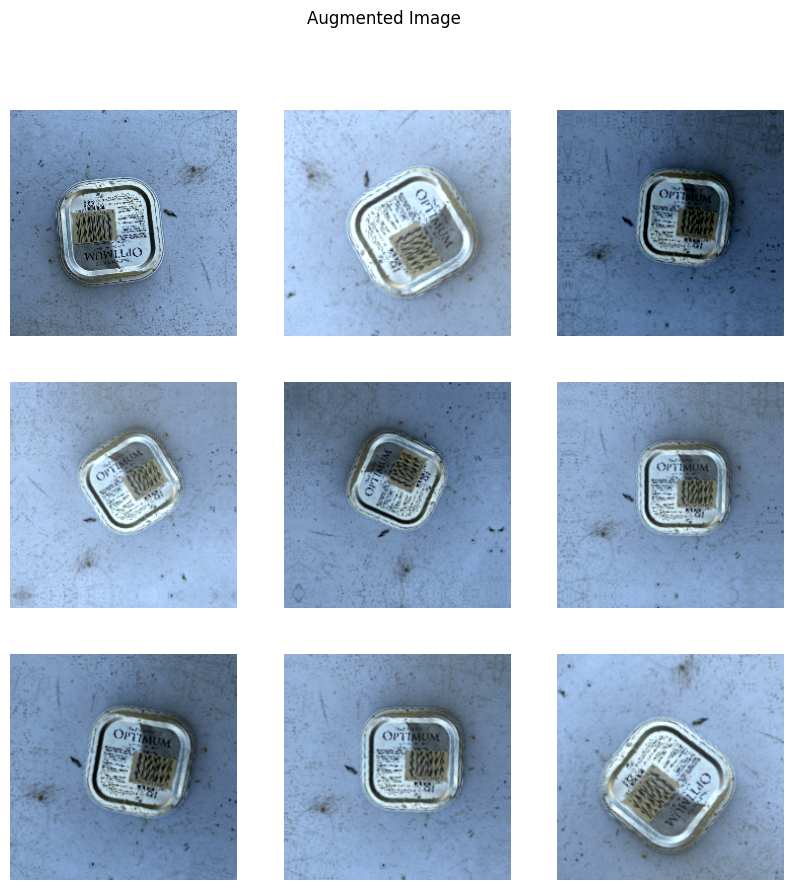

In [8]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [9]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [10]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [11]:

# 1. Shuffle once with seed BEFORE splitting
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

# 2. Split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# 3. Perform split
train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


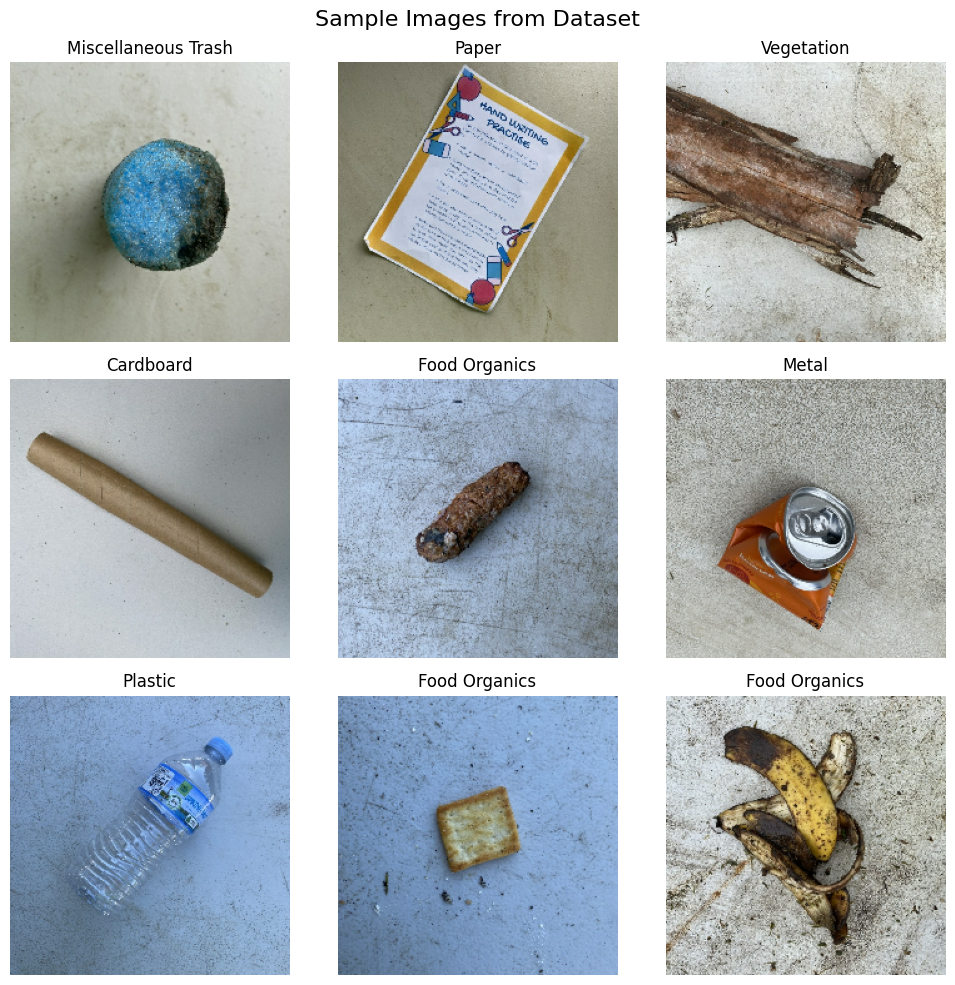

In [12]:


plt.figure(figsize=(10, 10))

    # Take 1 batch
for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]         # Extract one image from the batch
    label_idx = labels[i].numpy()  # Get class index

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Convert to displayable format
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



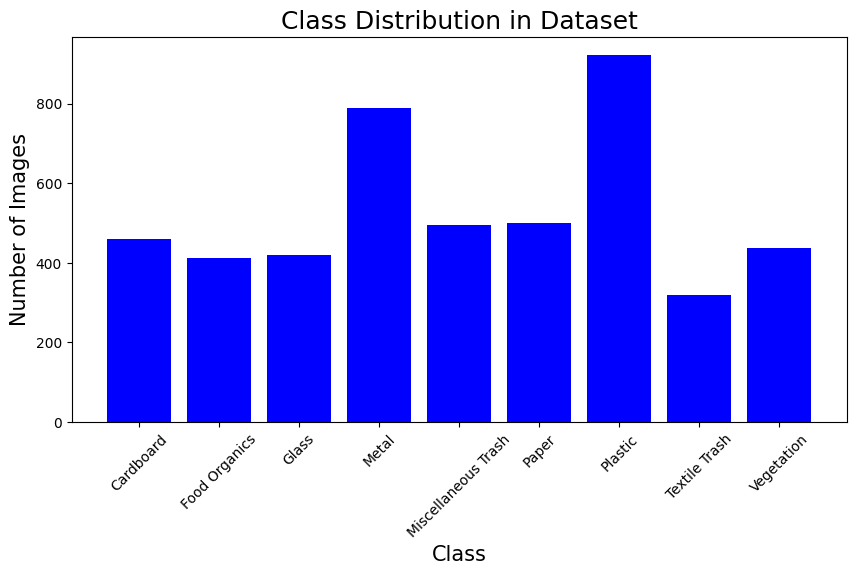

In [13]:

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [14]:
label_extraction_ds = dataset.shuffle(buffer_size=dataset_size, seed=42).take(train_size)
label_extraction_ds = label_extraction_ds.unbatch().batch(256)

train_labels = []

for batch in label_extraction_ds:
    _, labels = batch

    if tf.rank(labels).numpy() > 1:
        labels = tf.argmax(labels, axis=1)

    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)




Class weights: {0: np.float64(1.1393188854489165), 1: np.float64(1.3189964157706093), 2: np.float64(1.2225913621262459), 3: np.float64(0.6571428571428571), 4: np.float64(1.0605187319884726), 5: np.float64(1.0605187319884726), 6: np.float64(0.5670261941448382), 7: np.float64(1.7951219512195122), 8: np.float64(1.2225913621262459)}


In [15]:
@register_keras_serializable()
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

In [16]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:

        return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)

In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [75]:



input_layer = Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output_layer = layers.Dense(num_classes, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


model.summary()


Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 491,721 (1.88 MB)

 Trainable params: 489,993 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [76]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[lr_scheduler, reduce_lr])

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 61s 433ms/step - accuracy: 0.2078 - loss: 3.0765 - val_accuracy: 0.0974 - val_loss: 2.9282 - learning_rate: 0.0010
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 444ms/step - accuracy: 0.3067 - loss: 2.4109 - val_accuracy: 0.0852 - val_loss: 4.0074 - learning_rate: 0.0010
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 439ms/step - accuracy: 0.3349 - loss: 2.2504 - val_accuracy: 0.1790 - val_loss: 3.5243 - learning_rate: 0.0010
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3494 - loss: 2.1338
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 438ms/step - accuracy: 0.3497 - loss: 2.1333 - val_accuracy: 0.1548 - val_loss: 3.0143 - learning_rate: 0.0010
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 436ms/step - accuracy: 0.3938 - loss: 2.0081 - val_accuracy: 0.3239 - val_loss: 2.3255 - learning_rate: 5.0000e-04
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 435ms/step - accuracy: 0

In [38]:
model.save("/content/drive/MyDrive/my_model.h5")

In [77]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [78]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77        76
           1       0.54      0.49      0.52        51
           2       0.79      0.59      0.68        71
           3       0.50      0.62      0.55       125
           4       0.43      0.17      0.24        60
           5       0.35      0.86      0.49        64
           6       0.71      0.29      0.42       139
           7       0.67      0.26      0.37        47
           8       0.55      1.00      0.71        71

    accuracy                           0.55       704
   macro avg       0.60      0.55      0.53       704
weighted avg       0.61      0.55      0.53       704



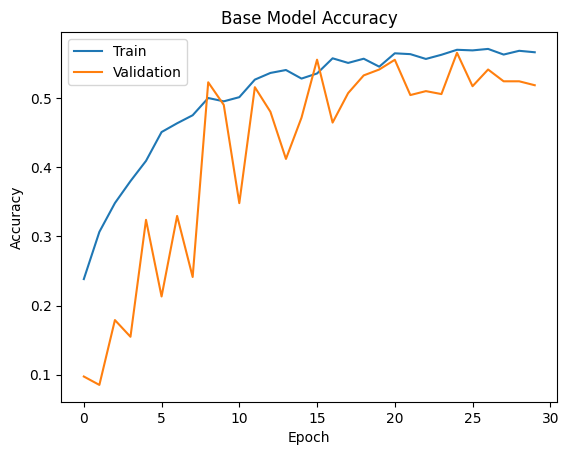

In [79]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

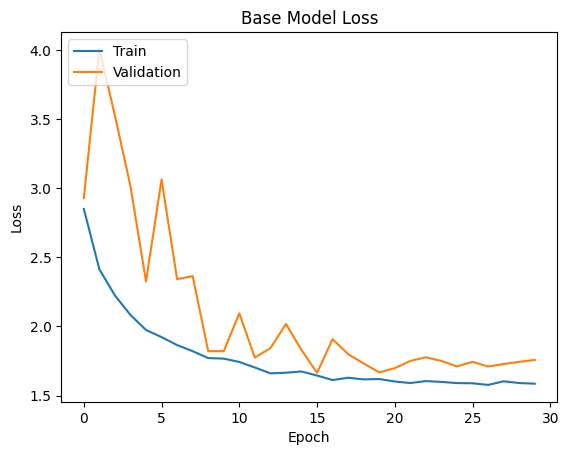

In [80]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

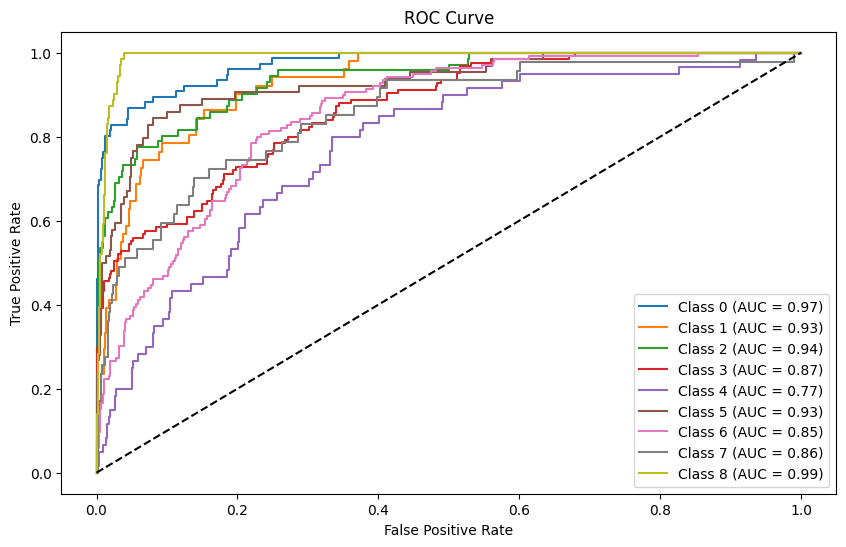

In [81]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

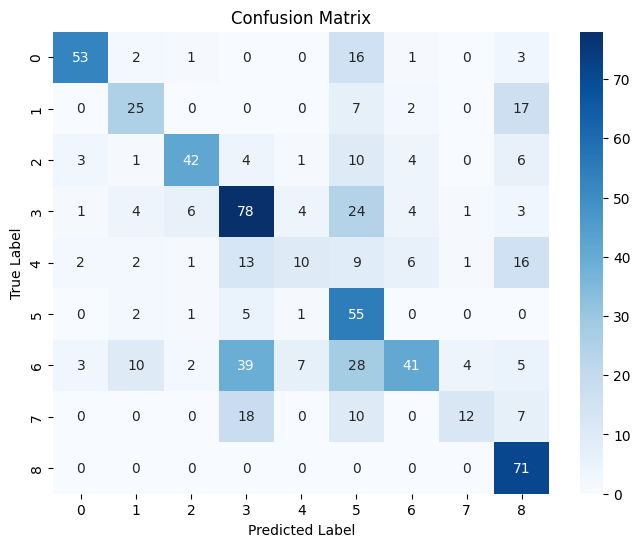

In [82]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [83]:

test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5151 - loss: 1.7705
Test Accuracy: 0.5149
Test Loss: 1.7685


In [155]:
def build_model(hp):
    inputs = Input(shape=(224, 224, 3))

    l2_value = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')

    # Conv Block 1
    x = layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Conv Block 2
    x = layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Conv Block 3
    x = layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(
        hp.Int("units", min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_value)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout1', min_value=0.3, max_value=0.6, step=0.1))(x)


    x = layers.Dense(
        hp.Int("units", min_value=128, max_value=512, step=64),
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_value)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout2', min_value=0.3, max_value=0.6, step=0.1))(x)



    outputs = layers.Dense(9, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=outputs)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss= CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model


In [156]:
 rm -rf my_tuning/cnn_baseline


In [129]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [158]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, class_weight=class_weights_dict, callbacks=[early_stop])


Trial 5 Complete [00h 08m 58s]
val_accuracy: 0.2485465109348297

Best val_accuracy So Far: 0.39346590638160706
Total elapsed time: 00h 42m 14s


In [159]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [160]:
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr]
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 429ms/step - accuracy: 0.1801 - loss: 3.7110 - val_accuracy: 0.1406 - val_loss: 3.4336 - learning_rate: 0.0010
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - accuracy: 0.2425 - loss: 3.2414 - val_accuracy: 0.1264 - val_loss: 3.5286 - learning_rate: 0.0010
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 452ms/step - accuracy: 0.3127 - loss: 2.9676 - val_accuracy: 0.1023 - val_loss: 3.6724 - learning_rate: 0.0010
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 453ms/step - accuracy: 0.3293 - loss: 2.7530 - val_accuracy: 0.1548 - val_loss: 3.0963 - learning_rate: 0.0010
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 462ms/step - accuracy: 0.3547 - loss: 2.5770 - val_accuracy: 0.2955 - val_loss: 2.6319 - learning_rate: 0.0010
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 450ms/step - accuracy: 0.3958 - loss: 2.3942 - val_accuracy: 0.4020 - val_loss: 2.3316 - learning_rate: 0.0010
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - accuracy: 0.3

In [161]:
best_model.save("/content/drive/MyDrive/my_best_model.h5")

In [162]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [163]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.48      0.76      0.59        62
           1       0.80      0.12      0.21        66
           2       0.83      0.67      0.74        51
           3       0.60      0.64      0.62       114
           4       0.42      0.18      0.26        76
           5       0.33      0.89      0.48        91
           6       0.80      0.27      0.40       133
           7       0.42      0.38      0.40        50
           8       0.69      0.74      0.71        61

    accuracy                           0.51       704
   macro avg       0.60      0.52      0.49       704
weighted avg       0.60      0.51      0.48       704



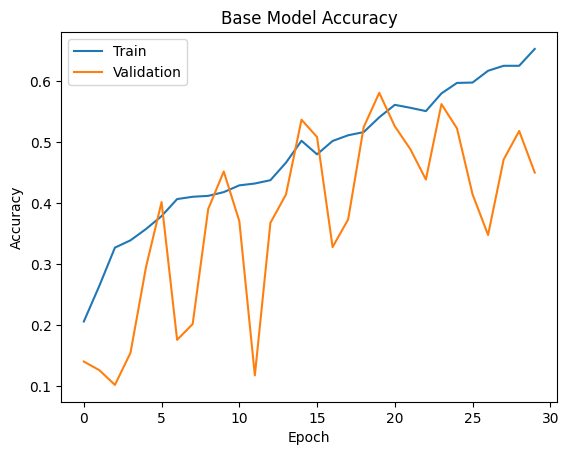

In [165]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

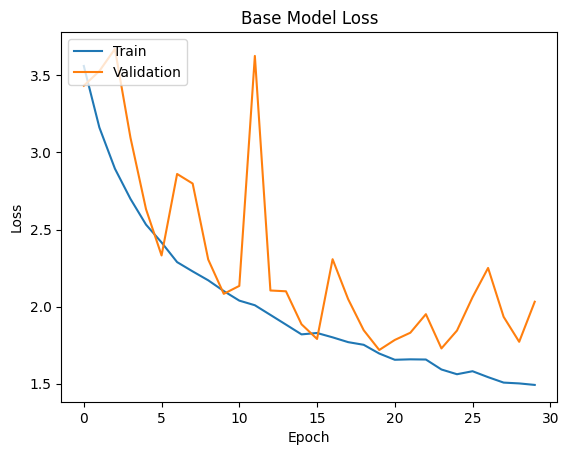

In [164]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

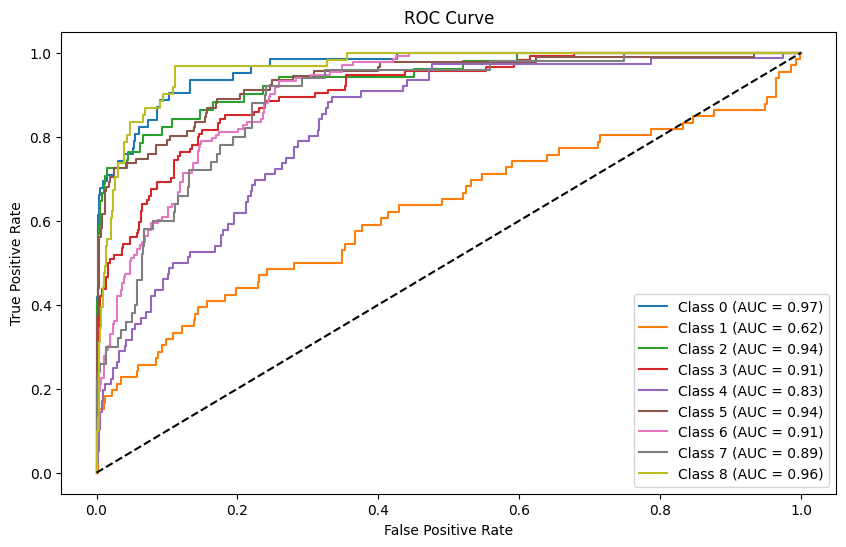

In [166]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

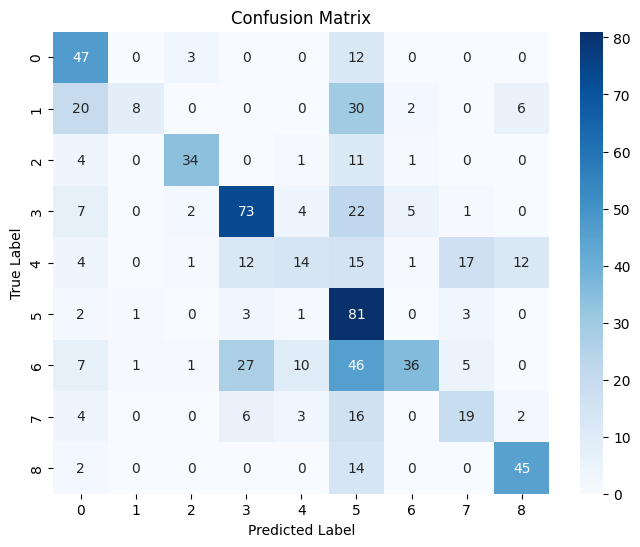

In [167]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [168]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            pred_label = np.argmax(predictions[i])

            ax = plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 images
            plt.imshow((image * 255).numpy().astype("uint8"))  # Denormalize
            plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=10)
            plt.axis("off")

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


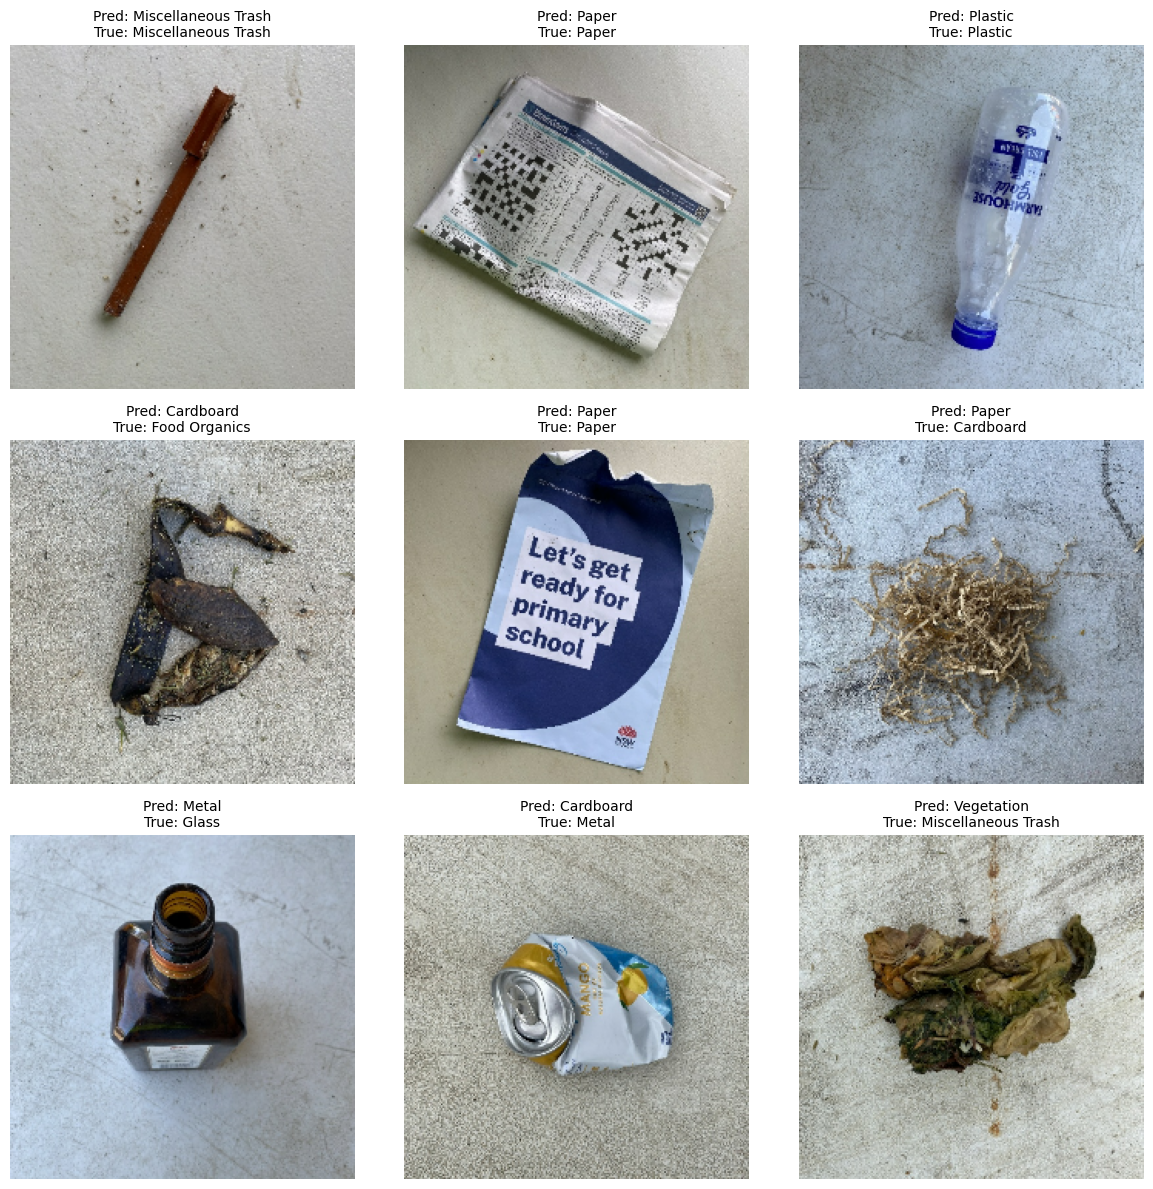

In [58]:
classify_from_dataset(best_model, test_dataset, class_names)

In [171]:
from tensorflow.keras.models import load_model


model = load_model(
    "/content/drive/MyDrive/my_best_model.h5",
    custom_objects={'categorical_focal_loss': categorical_focal_loss},
    compile=False  # 👈 avoids parsing the optimizer/loss
)

In [172]:
# Call the model with dummy input
dummy_input = np.zeros((1, 224, 224, 3), dtype=np.float32)

# This line is essential to "build" the model
_ = model(dummy_input)  # Don't skip this!

# Now you can safely extract features
from tensorflow.keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

In [174]:
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        batch_features = feature_model.predict(batch_images)
        features.append(batch_features)
        labels.append(np.argmax(batch_labels.numpy(), axis=1))  # Convert one-hot to label

    return np.vstack(features), np.concatenate(labels)

In [175]:
X_train, y_train = extract_features(train_dataset, feature_extractor)
X_test, y_test = extract_features(test_dataset, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [176]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_names))

SVM Accuracy: 0.44429347826086957
                     precision    recall  f1-score   support

          Cardboard       0.54      0.67      0.60        88
      Food Organics       0.29      0.07      0.11        59
              Glass       0.84      0.38      0.53        55
              Metal       0.62      0.41      0.49       120
Miscellaneous Trash       0.30      0.39      0.34        79
              Paper       0.28      0.86      0.42        74
            Plastic       0.59      0.35      0.44       136
      Textile Trash       0.38      0.34      0.36        62
         Vegetation       0.81      0.48      0.60        63

           accuracy                           0.44       736
          macro avg       0.52      0.44      0.43       736
       weighted avg       0.52      0.44      0.44       736

